In [1]:
#get all of the packages needed
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

In [2]:
#download the data and do a little cleanup
def convert_lat_long(value):
    if value[-1] == 'S' or value[-1] == 'W':
        return -1 * float(value[:-1])
    else:
        return float(value[:-1])

df = pd.read_csv('atlantic (2).csv')

df = df.loc[47750:].copy()

df.drop(['status_of_system', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8','Unnamed: 9', 
        'Unnamed: 10', 'Unnamed: 11','Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 
        'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18'], inplace=True, axis=1)
df['date'] = pd.to_datetime(df['date'], format = "%Y%m%d").dt.strftime('%Y-%m-%d')
df['date'] = df['date'].apply(lambda x: float(x.split()[0].replace('-', '')))

df['latitude'] = df['latitude'].map(lambda x: convert_lat_long(x))
df['longitude'] = df['longitude'].map(lambda x: convert_lat_long(x))

df['central_pressure'] = df['central_pressure'].fillna(method='ffill', limit=1000)
df['central_pressure'] = df['central_pressure'].fillna(method='bfill', limit=1000)
df['max_sustained_wind'] = df['max_sustained_wind'].replace(-99, np.nan)

df['date'] = pd.to_datetime(df['date'], format = "%Y%m%d").dt.strftime('%Y-%m-%d') 
df = df.set_index('date')

y = df['max_sustained_wind'].fillna(method='ffill')
y = y.values.reshape(-1, 1)
df

,latitude,longitude,max_sustained_wind,central_pressure
date,,,,
2012-08-23,14.8,-41.1,35,1007.0
2012-08-23,15.5,-42.1,35,1006.0
2012-08-24,16.1,-43.2,30,1008.0
2012-08-24,16.7,-44.3,30,1008.0
2012-08-24,17.4,-45.4,30,1009.0
...,...,...,...,...
2015-11-12,41.3,-50.4,55,981.0
2015-11-12,41.9,-49.9,55,983.0
2015-11-13,41.5,-49.2,50,985.0


In [3]:
# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

In [4]:
# generate the input and output sequences
n_lookback = 400  # length of input sequences (lookback period)
n_forecast = 500  # length of output sequences (forecast period)

In [5]:
X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

In [6]:
# fit the model
model = Sequential()
model.add(LSTM(units=5, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=5))
model.add(Dense(n_forecast))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=16, verbose=0)

In [7]:
# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

1/1 [==============================] - 0s 367ms/step


C:\Users\AadiT\AppData\Local\Temp\ipykernel_70728\3785833062.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsLatitude = df_past.append(df_future).set_index('Date')


<AxesSubplot: title={'center': 'Latitude Predictor'}, xlabel='Date'>

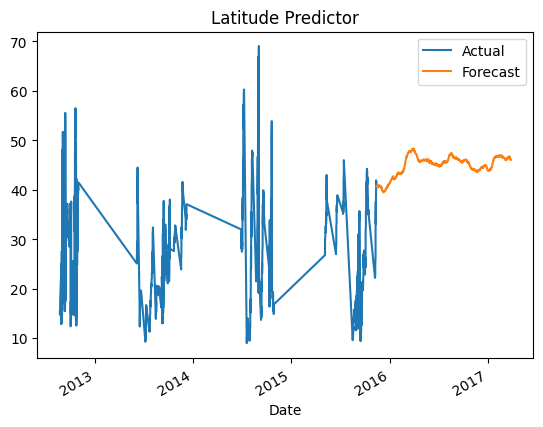

In [11]:
# organize the results in a data frame
df_past = df[['latitude']].reset_index()
df_past.rename(columns={'date' : 'Date', 'latitude': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]
df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Forecast'] = df_future['Forecast']
df_future['Actual'] = np.nan

resultsLatitude = df_past.append(df_future).set_index('Date')

# plot the results
resultsLatitude.plot(title='Latitude Predictor')